In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import json

/home/theo/anaconda3/envs/openmmlab/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def estimate_uncertainty(method, tensor):
    '''
    Estimate classification uncertainty.
    Arguments:
    
    method (str): name of method used to compute uncertainty
    tensor (torch.tensor): output of classification network, dimension ( N(images), N(classes) )
    Returns:
    torch.tensor with dimension ( N(images) )
    '''
    tensor = torch.nn.functional.softmax(tensor, dim=1)
    
    if method == 'MarginSampling':
        return margin_sampling(tensor)
    elif method == 'Entropy':
        return entropy(tensor)
    elif method == 'VarRatio':
        return var_ratio(tensor)

def margin_sampling(tensor):
    '''
    Measure uncertainty as 1 - difference between probabilities of the two highest-ranking classes
    '''
    tensor_sorted = tensor.sort(dim=1, descending=True)[0] # sort class probabilities
    return 1 - (tensor_sorted[:,0] - tensor_sorted[:,1])

def entropy(tensor):
    '''
    Measure uncertainty as predictive entropy
    '''
    tensor_log = tensor.log()
    return -(tensor*tensor_log).sum(dim=1)

def var_ratio(tensor):
    '''
    Measure uncertainty as 1 - probability of highest-ranking class
    '''
    return 1 - tensor.max(dim=1)[0]

In [3]:
def select_images(method, tensor, n_sel, **kwargs):
    '''
    Select set of unlabelled images to be added to training set
    Arguments:
    
    method (str): name of method used to select images
    tensor (torch.tensor): output of aggregate_uncertainty, dimension ( N(images) )
    n_sel (int): number of images to select
    Returns:
    torch.tensor with index of selected images, dimension ( n_sel )
    '''

    if method == 'batch':
        return batch_selection(tensor, n_sel, **kwargs)
    elif method == 'maximum':
        return maximum_selection(tensor, n_sel)
    elif method == 'CoreSet':
        return core_set(tensor, n_sel, **kwargs)

def batch_selection(tensor, n_sel, **kwargs):
    '''
    Split randomly shuffled images in batches, compute aggregate score (sum) for each batch and select highest scores until n_sel is reached.
    Necessary keyword argument:
    batch_size (int): number of images per batch
    '''
    if (n_sel % kwargs['batch_size']) == 0:
        batch_size_sel = int(n_sel / kwargs['batch_size'])
    else:
        batch_size_sel = (n_sel // kwargs['batch_size']) + 1
    
    r = torch.randperm(tensor.shape[0])
    tensor_shuffle = tensor[r] # randomly shuffle images

    batch_list = tensor_shuffle.split(kwargs['batch_size'])
    batch_score_tensor = torch.tensor( [ b.sum().item() for b in batch_list ] )
    batch_argmax = batch_score_tensor.sort(descending=True)[1][:batch_size_sel]

    arg_sel = torch.concat( [r.split(kwargs['batch_size'])[ib] for ib in range(len(batch_list)) if ib in batch_argmax] )

    return arg_sel

def maximum_selection(tensor, n_sel):
    '''
    Select the n_sel images with the highest uncertainty.
    '''
    return tensor.sort(descending=True)[1][:n_sel]

def core_set(tensor, n_sel, **kwargs):
    '''
    k-center greedy, limited to pool set and with distance weighted by uncertainty
    '''
    # compute matrix of distances between images
    dist_mat = kwargs['embedding'] @ kwargs['embedding'].transpose(0, 1)
    diag = dist_mat.diag().reshape( (kwargs['embedding'].shape[0], 1) )
    dist_mat *= -2
    dist_mat += diag
    dist_mat += diag.transpose(0, 1)
    dist_mat = torch.sqrt(dist_mat)

    # choose first centroid randomly
    centroids = torch.zeros(tensor.shape[0], dtype=torch.bool)
    sel_idx = torch.randint( kwargs['embedding'].shape[0], (1,1) ).squeeze().item()
    centroids[sel_idx] = True
    
    # select centroids (= data to be labelled) iteratively
    for _ in range(n_sel-1):
        d = dist_mat[~centroids][:,centroids] # remove centroids from row and keep only centroids for columns
        unc = tensor[~centroids] # get uncertainty of images other than centroids
        
        mat_min = d.min(dim=1)[0] # get closest centroid for each image
        weighted_mat_min = mat_min * unc # weight distance to closest centroid by uncertainty on image
        sel_idx_ = weighted_mat_min.argmax().item() # select image with largest distance to closest centroid
        sel_idx = torch.arange(tensor.shape[0])[~centroids][sel_idx_] # correct index for already selected images/rows
        centroids[sel_idx] = True

    return torch.arange(tensor.shape[0])[centroids]

In [4]:
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [5]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x, embedding=False, loss_prediction=False):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        feat_map_1 = self.layer1(out)
        feat_map_2 = self.layer2(feat_map_1)
        feat_map_3 = self.layer3(feat_map_2)
        out = self.avg_pool(feat_map_3)
        feat_vec = out.view(out.size(0), -1)
        out = self.fc(feat_vec)
        if embedding:
            return out, feat_vec # for core-set selection
        elif loss_prediction:
            return out, [feat_map_1, feat_map_2, feat_map_3]
        else:
            return out

In [6]:
class LossPredictionModule(nn.Module):
    def __init__(self):
        super(LossPredictionModule, self).__init__()
        self.fc1 = nn.Linear(16, 64)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc_out = nn.Linear(3*64, 1)

    def forward(self, features):
        out1 = features[0].mean(dim=(-2,-1))
        out1 = F.relu(self.fc1(out1))

        out2 = features[1].mean(dim=(-2,-1))
        out2 = F.relu(self.fc2(out2))

        out3 = features[2].mean(dim=(-2,-1))
        out3 = F.relu(self.fc3(out3))

        out = torch.cat((out1, out2, out3), dim=1)
        out = self.fc_out(out).squeeze()

        return out

In [7]:
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
# Train the model
def train_model(models, optimizers, train_loader, learning_rate, num_epochs, epoch_loss=48, margin=1, weight=1):
    
    models['resnet'].train()
    if len(models) > 1:
        models['module'].train()
    total_step = len(train_loader)
    curr_lr = learning_rate
    
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            if len(models) > 1:
                criterion = nn.CrossEntropyLoss(reduction='none')
                
                outputs, features = models['resnet'](images, loss_prediction=True)
                loss_target = criterion(outputs, labels)
                
                if epoch > epoch_loss:
                    # After 48 epochs, stop the gradient from the 
                    #loss prediction module propagated to the target model.
                    features[0] = features[0].detach()
                    features[1] = features[1].detach()
                    features[2] = features[2].detach()
                loss_pred = models['module'](features)

                loss_pred_pairs = loss_pred.reshape(-1,2)
                loss_target_pairs = loss_target.reshape(-1,2)
                
                ones = torch.ones(loss_target_pairs.shape[0], dtype=torch.double).to(device)
                pm = torch.where(loss_target_pairs[:,0] > loss_target_pairs[:,1], ones, -1.)
                
                loss_module = -1 * pm * (loss_pred_pairs[:,0] - loss_pred_pairs[:,1]) + margin
                loss_module = torch.where(loss_module > 0, loss_module, 0.)

                loss = loss_target.mean() + weight * loss_module.mean()

#                crit_module = MarginRankingLoss_learning_loss()
#                loss_module = crit_module(loss_pred, loss_target)                
#                loss = loss_target.mean() + weight * loss_module
                
#                loss_module = LossPredLoss(loss_pred, loss_target)
#                loss = loss_target.mean() + weight * 2 * loss_module

            else:
                criterion = nn.CrossEntropyLoss()
                outputs = models['resnet'](images)
                loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizers['resnet'].step()
            if len(models) > 1:
                optimizers['module'].step()

            if epoch % 40 == 0:
                if i == 10:
                    print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        # Decay learning rate
        if (epoch+1) % 20 == 0:
            curr_lr /= 3
            update_lr(optimizer, curr_lr)


In [9]:
# Test the model
def test_model(models, test_loader):
    models['resnet'].eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = models['resnet'](images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))
        return 100 * correct / total

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

In [12]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)

Files already downloaded and verified


In [17]:
# Hyper-parameters
num_epochs = 80
learning_rate = 0.001
epoch_loss = 48

n_round = 10
n_sel = 1000
n_repeat = 3
unc_method = 'MarginSampling'
sel_method = 'maximum'

loss_prediction = False
if unc_method == 'LossPrediction':
    loss_prediction = True

In [18]:
torch.manual_seed(0)

for irepeat in range(n_repeat):

    train, pool = torch.utils.data.random_split(train_dataset, [1000, len(train_dataset)-1000])
    #pool, _ = torch.utils.data.random_split(pool, [int(len(pool)/2), int(len(pool)/2)]) # ugly hack to reduce memory for Core-set

    train_loader = torch.utils.data.DataLoader(dataset=train,
                                               batch_size=100, 
                                               shuffle=True)
    accuracy_list = []

    # create model
    models = {}
    model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    models['resnet'] = model
    if loss_prediction:
        module = LossPredictionModule().to(device)
        models['module'] = module

    for ir in range(n_round):
        print(f'Round {ir}')
        
        optimizers = {}        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        optimizers['resnet'] = optimizer
        if loss_prediction:
            optim_module = torch.optim.Adam(module.parameters(), lr=learning_rate)
            optimizers['module'] = optim_module

        # train
        train_model(models, optimizers, train_loader, learning_rate, num_epochs)

        # test
        accuracy_list.append( test_model(models, test_loader) )

        if sel_method == 'random':
            sel_idx = torch.randint(len(pool), (n_sel,))
        else:
            # inference on pool set
            # select from subset of 10000 images, to avoid bias due to similar images with high uncertainty
            pool_subset, pool_rest = torch.utils.data.random_split(pool, [10000, len(pool)-10000])
            pool_subset_loader = torch.utils.data.DataLoader(dataset=pool_subset,
                                                              batch_size=100, 
                                                              shuffle=False)

            uncertainty = []
            embedding = []

            models['resnet'].eval()
            if loss_prediction:
                models['module'].eval()
                
            with torch.no_grad():
                for images, labels in pool_subset_loader:
                    images = images.to(device)
                    if loss_prediction:
                        features = models['resnet'](images, loss_prediction=True)[1]
                        unc = models['module'](features)                        
                    else:
                        if sel_method == 'CoreSet':
                            outputs, embed = models['resnet'](images, embedding=True)
                            embedding.append(embed)
                        else:
                            outputs = models['resnet'](images)
                        unc = estimate_uncertainty(unc_method, outputs)
                    uncertainty.append(unc)
            uncertainty = torch.cat(uncertainty)
            
            if sel_method == 'CoreSet':
                embedding = torch.cat(embedding)
                lin_mat = torch.ones([embedding.shape[1], 4], device=f'cuda:{torch.cuda.current_device()}')
                embedding = embedding @ lin_mat
                del lin_mat

            # select images to label from pool and add to training set
            sel_idx = select_images(sel_method, uncertainty, n_sel, batch_size=10, embedding=embedding)
        selected = torch.utils.data.Subset(pool_subset, sel_idx)
        train = torch.utils.data.ConcatDataset([train, selected])

        # keep only non-selected images in pool
        mask = torch.ones(len(pool_subset), dtype=torch.bool)
        mask[sel_idx] = False
        not_sel_idx = torch.arange(mask.shape[0])[mask]
        pool = torch.utils.data.ConcatDataset( [pool_rest, torch.utils.data.Subset(pool_subset, not_sel_idx)] )

        # make new loaders
        train_loader = torch.utils.data.DataLoader(dataset=train,
                                                   batch_size=100, 
                                                   shuffle=True)
        pool_loader = torch.utils.data.DataLoader(dataset=pool,
                                                   batch_size=100, 
                                                   shuffle=False)
        torch.cuda.empty_cache()
        print('')

    if sel_method == 'random':
        with open(f'output/random_{irepeat}.json', 'w') as f:
            json.dump(accuracy_list, f)
    else:
        with open(f'output/{unc_method}_{sel_method}_{irepeat}.json', 'w') as f:
            json.dump(accuracy_list, f)            

Round 0
Accuracy of the model on the test images: 49.92 %

Round 1
Epoch [1/80], Step [11/20] Loss: 1.7958
Epoch [41/80], Step [11/20] Loss: 0.3983
Accuracy of the model on the test images: 57.55 %

Round 2
Epoch [1/80], Step [11/30] Loss: 1.1775
Epoch [41/80], Step [11/30] Loss: 0.2481
Accuracy of the model on the test images: 63.52 %

Round 3
Epoch [1/80], Step [11/40] Loss: 1.1879
Epoch [41/80], Step [11/40] Loss: 0.1324
Accuracy of the model on the test images: 68.0 %

Round 4
Epoch [1/80], Step [11/50] Loss: 1.0221
Epoch [41/80], Step [11/50] Loss: 0.0902
Accuracy of the model on the test images: 71.75 %

Round 5
Epoch [1/80], Step [11/60] Loss: 0.8155
Epoch [41/80], Step [11/60] Loss: 0.1016
Accuracy of the model on the test images: 74.54 %

Round 6
Epoch [1/80], Step [11/70] Loss: 0.7596
Epoch [41/80], Step [11/70] Loss: 0.0654
Accuracy of the model on the test images: 76.17 %

Round 7
Epoch [1/80], Step [11/80] Loss: 0.6018
Epoch [41/80], Step [11/80] Loss: 0.1415
Accuracy of t

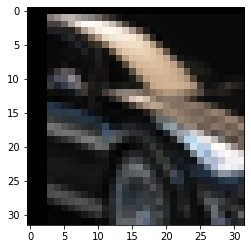

In [33]:
plt.imshow(torch.permute(selected[0][0].cpu(), (1,2,0)))

In [32]:
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([100, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([100, 64, 1, 1])
<class 'torch.Tensor'> torch.Size([100, 64])
<class 'torch.Tensor'> torch.Size([100, 10])
<class 'torch.Tensor'> torch.Size([100])
<class 'torch.Tensor'> torch.Size([49000])
<class 'torch.Tensor'> torch.Size([49000, 4])
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 3, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([10, 64])
<class 'torch.nn.parameter.Parameter'> torch.Size([10])
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 16, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torch.Size([16, 16, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([16])
<class 'torch.nn.parameter.Parameter'> torc

In [23]:
# Example of target with class indices
loss = nn.CrossEntropyLoss(reduction='none')
input = torch.randn(4, 5, requires_grad=True)
target = torch.empty(4, dtype=torch.long).random_(5)
output = loss(input, target)

In [24]:
input

tensor([[ 0.7518, -0.5871,  0.8098,  0.0913, -0.3258],
        [ 1.5572, -0.1011,  0.2457,  1.6983, -0.3345],
        [ 0.2467,  0.2393, -0.4506, -0.3468, -0.1449],
        [ 0.6332, -0.3069, -0.3725, -0.7686, -0.7112]], requires_grad=True)

In [25]:
margin = 1
criterion = nn.CrossEntropyLoss(reduction='none')

loss_target = criterion(input, target)
loss_pred = torch.randn(loss_target.shape[0])

In [26]:
loss_target

tensor([2.4954, 1.0160, 1.3208, 2.2186], grad_fn=<NllLossBackward0>)

In [27]:
loss_pred

tensor([-0.7524, -0.1346,  0.0573, -1.2509])

In [28]:
loss_pred_pairs = loss_pred.reshape(-1,2)
print(loss_pred_pairs)
loss_target_pairs = loss_target.reshape(-1,2)
print(loss_target_pairs)
ones = torch.ones(loss_target_pairs.shape[0], dtype=torch.double)
pm = torch.where(loss_target_pairs[:,0] > loss_target_pairs[:,1], ones, -1.)
print(pm)

loss_module = -1 * pm * (loss_pred_pairs[:,0] - loss_pred_pairs[:,1]) + margin
print(loss_module)
loss_module = torch.where(loss_module > 0, loss_module, 0.)
loss_module

tensor([[-0.7524, -0.1346],
        [ 0.0573, -1.2509]])
tensor([[2.4954, 1.0160],
        [1.3208, 2.2186]], grad_fn=<ReshapeAliasBackward0>)
tensor([ 1., -1.], dtype=torch.float64)
tensor([1.6178, 2.3082], dtype=torch.float64)


tensor([1.6178, 2.3082], dtype=torch.float64)

In [43]:
def LossPredLoss(input, target, margin=1.0, reduction='mean'):
    assert len(input) % 2 == 0, 'the batch size is not even.'
    assert input.shape == input.flip(0).shape
    
    input = (input - input.flip(0))[:len(input)//2] # [l_1 - l_2B, l_2 - l_2B-1, ... , l_B - l_B+1], where batch_size = 2B
    target = (target - target.flip(0))[:len(target)//2]
    target = target.detach()
    one = 2 * torch.sign(torch.clamp(target, min=0)) - 1 # 1 operation which is defined by the authors
    if reduction == 'mean':
        loss = torch.sum(torch.clamp(margin - one * input, min=0))
        loss = loss / input.size(0) # Note that the size of input is already halved
    elif reduction == 'none':
        loss = torch.clamp(margin - one * input, min=0)
    else:
        NotImplementedError()
    
    return loss

In [44]:
LossPredLoss(loss_pred, loss_target)

tensor(0.6548)

In [45]:
class MarginRankingLoss_learning_loss(nn.Module):
    def __init__(self, margin=1.0):
        super(MarginRankingLoss_learning_loss, self).__init__()
        self.margin = margin
    def forward(self, inputs, targets):
        random = torch.randperm(inputs.size(0))
        pred_loss = inputs[random]
        pred_lossi = inputs[:inputs.size(0)//2]
        pred_lossj = inputs[inputs.size(0)//2:]
        target_loss = targets.reshape(inputs.size(0), 1)
        target_loss = target_loss[random]
        target_lossi = target_loss[:inputs.size(0)//2]
        target_lossj = target_loss[inputs.size(0)//2:]
        final_target = torch.sign(target_lossi - target_lossj)
        
        return F.margin_ranking_loss(pred_lossi, pred_lossj, final_target, margin=self.margin, reduction='mean')     

In [46]:
criterion = MarginRankingLoss_learning_loss()
criterion(loss_pred, loss_target)

tensor(1.0291, grad_fn=<MeanBackward0>)